In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns 
from matplotlib import pyplot as plt
import hashlib

from bias_tree import BiasDetectionTree, get_metric_bias_tree_for_model, evaluate_model
from data_preparation.movielens_100k import MovieLens100KData
from data_preparation.book_crossing import BookCrossingData
from recommender.factorization_recommender import fit_recommendation_model, retrain_recommendation_model,\
tune_recommendation_hyperparams, BiasEvaluationCallback

### Prepare training data

In [2]:
data = MovieLens100KData(data_path='data/ml-100k') #BookCrossingData(data_path='data/book-crossing') #MovieLens100KData(data_path='data/ml-100k')

### Analyze minimum and maximum biased nodes during training

In [3]:
NUM_EPOCH = 50
BATCH_SIZE = 1000
MAX_TRIAL = 50
BIAS_EVAL_INTERVAL = 2
EMBEDDING_SIZE = 128
MIN_CHILD_NODE_SIZE = 1000

In [ ]:
bias_results_runs = []


X_train, X_val, X_test = data.get_data_splits_for_training()
bias_callback = BiasEvaluationCallback(X_train, X_val, data, interval=BIAS_EVAL_INTERVAL, 
                                       min_child_node_size=MIN_CHILD_NODE_SIZE, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED)
model, history =  fit_recommendation_model(X_train, X_val, user_ids=data.user_ids, item_ids=data.item_ids, 
                                             batch_size=BATCH_SIZE, epochs=NUM_EPOCH, callbacks=[bias_callback], 
                                           embedding_size=EMBEDDING_SIZE, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED)
bias_results_runs += bias_callback.bias_results

In [ ]:
bias_results_epochs = pd.DataFrame(bias_results_runs)

bias_results_epochs = bias_results_epochs[bias_results_epochs['epoch']>0]

bias_results_epochs.replace('train-min node', 'train: min node value', inplace=True)
bias_results_epochs.replace('train-max node', 'train: max node value', inplace=True)
bias_results_epochs.replace('val-min node', 'validation: min node value', inplace=True)
bias_results_epochs.replace('val-max node', 'validation: max node value', inplace=True)
bias_results_epochs.replace('avg-train', 'train: average value', inplace=True)
bias_results_epochs.replace('avg-val', 'validation: average value', inplace=True)
bias_results_epochs.rename(columns={'value': 'MSE'}, inplace=True)

plt.figure(figsize=(10,10))
ax = sns.lineplot(data=bias_results_epochs, x='epoch', y='MSE', hue='metric')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

In [ ]:
bias_results_epochs.to_excel('bias_node_results_dnn_10runs.xls')

### Hyperparameter tuning

In [4]:
MIN_CHILD_NODE_SIZE = 1000
METRIC = 'squared_error'
NUM_EPOCH = 30

#### Tuning for the global validation set

In [5]:
now = datetime.now().strftime("%Y%m%d %H%M%S")
X_train, X_val, X_test = data.get_data_splits_for_training()
model =  tune_recommendation_hyperparams(X_train, X_val, user_ids=data.user_ids, item_ids=data.item_ids, 
                                             batch_size=BATCH_SIZE, epochs=NUM_EPOCH, project_suffix=now, max_trials=MAX_TRIAL, 
                                         logdir='hyperparams', rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED)

Trial 5 Complete [00h 00m 15s]
val_loss: 0.9005972743034363

Best val_loss So Far: 0.9005972743034363
Total elapsed time: 00h 00m 36s
INFO:tensorflow:Oracle triggered exit
Epoch 1/40
59/59 [==============================] - 2s 14ms/step - loss: 10.9153 - val_loss: 1.1278
Epoch 2/40
59/59 [==============================] - 1s 9ms/step - loss: 0.9785 - val_loss: 0.9257
Epoch 3/40
59/59 [==============================] - 1s 9ms/step - loss: 0.8562 - val_loss: 0.9210
Epoch 4/40
59/59 [==============================] - 1s 9ms/step - loss: 0.8573 - val_loss: 0.9203
Epoch 5/40
59/59 [==============================] - 1s 9ms/step - loss: 0.8608 - val_loss: 0.9176
Epoch 6/40
59/59 [==============================] - 1s 10ms/step - loss: 0.8590 - val_loss: 0.9254
Epoch 7/40
59/59 [==============================] - 1s 10ms/step - loss: 0.8604 - val_loss: 0.9202


root=[]: 0.911
├── year_bucketized=['(1921.999, 1982.0]']: 0.805
├── year_bucketized=['(1982.0, 1993.0]', '(1993.0, 1995.0]']: 0.891
│   ├── gender=['F']: 1.017
│   └── gender=['M']: 0.849
└── year_bucketized=['(1995.0, 1996.0]', '(1996.0, 1998.0]']: 0.992
    ├── item popularity_bucketized=['(120.0, 176.0]', '(64.0, 120.0]', '(9.999, 64.0]']: 1.063
    │   ├── age_bucketized=['(23.0, 27.0]', '(44.0, 73.0]', '(33.0, 44.0]', '(27.0, 33.0]']: 0.997
    │   └── age_bucketized=['(6.999, 23.0]']: 1.256
    └── item popularity_bucketized=['(176.0, 264.0]', '(264.0, 583.0]']: 0.892



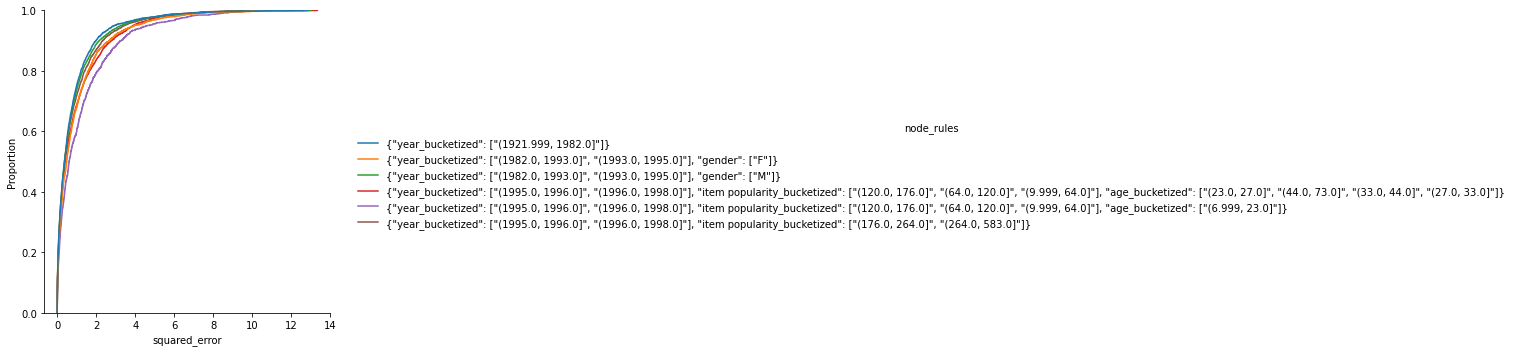

,count,mean,std,min,25%,50%,75%,max
node_rules,,,,,,,,
"{""year_bucketized"": [""(1921.999, 1982.0]""]}",4069.0,0.804584,1.272440,5.130119e-08,0.083249,0.373455,0.990060,12.826791
"{""year_bucketized"": [""(1982.0, 1993.0]"", ""(1993.0, 1995.0]""], ""gender"": [""M""]}",6090.0,0.848903,1.324884,3.878290e-08,0.080856,0.371090,1.055441,12.982933
"{""year_bucketized"": [""(1995.0, 1996.0]"", ""(1996.0, 1998.0]""], ""item popularity_bucketized"": [""(176.0, 264.0]"", ""(264.0, 583.0]""]}",3086.0,0.891676,1.321242,9.728620e-07,0.091968,0.382695,1.145401,12.067848
"{""year_bucketized"": [""(1995.0, 1996.0]"", ""(1996.0, 1998.0]""], ""item popularity_bucketized"": [""(120.0, 176.0]"", ""(64.0, 120.0]"", ""(9.999, 64.0]""], ""age_bucketized"": [""(23.0, 27.0]"", ""(44.0, 73.0]"", ""(33.0, 44.0]"", ""(27.0, 33.0]""]}",3229.0,0.997161,1.434994,6.471561e-08,0.091210,0.411989,1.312291,13.338114
"{""year_bucketized"": [""(1982.0, 1993.0]"", ""(1993.0, 1995.0]""], ""gender"": [""F""]}",2012.0,1.016946,1.500256,9.273163e-07,0.105565,0.479856,1.315925,12.610550
"{""year_bucketized"": [""(1995.0, 1996.0]"", ""(1996.0, 1998.0]""], ""item popularity_bucketized"": [""(120.0, 176.0]"", ""(64.0, 120.0]"", ""(9.999, 64.0]""], ""age_bucketized"": [""(6.999, 23.0]""]}",1105.0,1.256344,1.682608,1.585306e-07,0.144303,0.609465,1.671994,11.549037


In [6]:
bias_tree_test = get_metric_bias_tree_for_model(model, X_val, data.attributes_dict, 
                                                 metric_name=METRIC,
                                                min_child_node_size=MIN_CHILD_NODE_SIZE, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED)
display(bias_tree_test.leaf_metrics)

##### Maximum and minimum biased nodes

In [7]:
print(bias_tree_test.max_metric_node, round(bias_tree_test.max_metric_value, 3))

{"year_bucketized": ["(1995.0, 1996.0]", "(1996.0, 1998.0]"], "item popularity_bucketized": ["(120.0, 176.0]", "(64.0, 120.0]", "(9.999, 64.0]"], "age_bucketized": ["(6.999, 23.0]"]} 1.256


In [8]:
print(bias_tree_test.min_metric_node, round(bias_tree_test.min_metric_value, 3))

{"year_bucketized": ["(1921.999, 1982.0]"]} 0.805


### Hyperparameter tuning for the biased nodes

In [9]:
BATCH_SIZE_BIAS = 256
mean_test_metric = evaluate_model(model, X_test, METRIC, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED).mean() 
retrain_metrics = []
biased_nodes = bias_tree_test.leaf_metrics[bias_tree_test.leaf_metrics['mean'] > mean_test_metric]
for i, node_rules in biased_nodes.iterrows():
    print(node_rules.name,  node_rules["mean"])
    X_train_filtered = bias_tree_test.get_filtered_df(node_rules.name,  X_train)
    X_val_filtered = BiasDetectionTree.get_filtered_df(node_rules.name,  X_val)
    X_test_filtered = BiasDetectionTree.get_filtered_df(node_rules.name,  X_test)
    model_tuned_bias = tune_recommendation_hyperparams(X_train, X_val_filtered, user_ids=data.user_ids, item_ids=data.item_ids, 
                                 epochs=NUM_EPOCH, project_suffix=hashlib.md5(node_rules.name.encode()).hexdigest()[:5] + now,
                                                      batch_size=BATCH_SIZE_BIAS, max_trials=1, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED, item_col=data.ITEM_ID_COL_TRANSFORMED)
#     model_bias = retrain_recommendation_model(X_train, X_val_filtered, model=model, epochs=10, 
#                                               retrain_embeddings=False)    
    node_test_metric_after_retraining = evaluate_model(model_tuned_bias, X_test_filtered, METRIC, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED).mean()
    node_val_metric_after_retraining = evaluate_model(model_tuned_bias,  X_val_filtered, METRIC, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED).mean()
    node_test_metric_before_retraining = evaluate_model(model,  X_test_filtered, METRIC, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED).mean()
    node_val_metric_before_retraining = evaluate_model(model, X_val_filtered, METRIC, rating_col=data.RATING_COL, 
                                           user_col=data.USER_ID_COL_TRANSFORMED,
                                          item_col=data.ITEM_ID_COL_TRANSFORMED).mean()
    retrain_metrics.append({
        'node_rules': node_rules.name,
        'node_test_metric_before_retraining':  node_test_metric_before_retraining,
        'node_val_metric_before_retraining':  node_val_metric_before_retraining,
        'node_test_metric_after_retraining': node_test_metric_after_retraining,
        'node_val_metric_after_retraining': node_val_metric_after_retraining
    })
retrain_metrics_pd = pd.DataFrame(retrain_metrics)

Trial 1 Complete [00h 00m 12s]
val_loss: 1.2165298461914062

Best val_loss So Far: 1.2165298461914062
Total elapsed time: 00h 00m 12s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
230/230 [==============================] - 2s 5ms/step - loss: 6.2875 - val_loss: 1.3006
Epoch 2/10
230/230 [==============================] - 1s 5ms/step - loss: 0.9134 - val_loss: 1.3371
Epoch 3/10
230/230 [==============================] - 1s 4ms/step - loss: 0.9051 - val_loss: 1.2944
Epoch 4/10
230/230 [==============================] - 1s 4ms/step - loss: 0.8877 - val_loss: 1.2747
Epoch 5/10
230/230 [==============================] - 1s 4ms/step - loss: 0.8721 - val_loss: 1.2564
Epoch 6/10
230/230 [==============================] - 1s 4ms/step - loss: 0.8501 - val_loss: 1.2264
Epoch 7/10
230/230 [==============================] - 1s 4ms/step - loss: 0.8242 - val_loss: 1.2120
Epoch 8/10
230/230 [==============================] - 1s 4ms/step - loss: 0.8047 - val_loss: 1.2122
Epoch 9/10
230/230 [========

In [10]:
retrain_metrics_pd['retrain_test_diff'] = 100*(retrain_metrics_pd['node_test_metric_before_retraining'] \
                                          - retrain_metrics_pd['node_test_metric_after_retraining'])\
                              /retrain_metrics_pd['node_test_metric_before_retraining']

retrain_metrics_pd['retrain_val_diff'] = 100*(retrain_metrics_pd['node_val_metric_before_retraining'] \
                                          - retrain_metrics_pd['node_val_metric_after_retraining'])\
                                          /retrain_metrics_pd['node_val_metric_before_retraining']
retrain_metrics_pd.round(3)

,node_rules,node_test_metric_before_retraining,node_val_metric_before_retraining,node_test_metric_after_retraining,node_val_metric_after_retraining,retrain_test_diff,retrain_val_diff
0,"{""year_bucketized"": [""(1995.0, 1996.0]"", ""(199...",1.011,0.997,1.012,0.994,-0.064,0.317
1,"{""year_bucketized"": [""(1982.0, 1993.0]"", ""(199...",1.027,1.017,0.991,0.973,3.565,4.304
2,"{""year_bucketized"": [""(1995.0, 1996.0]"", ""(199...",1.048,1.256,1.049,1.215,-0.041,3.318
